# ML Lab2
#### Author: Pumnia Mykhailo, KM-22
---

Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Step 1. Open [csv](./KM-22-1.csv) file

In [2]:
data = pd.read_csv('./KM-22-1.csv')
data

,GT,Model_1_0,Model_1_1,Model_2_0,Model_2_1
0,1,0.076819,0.923181,6.551695e-01,0.344830
1,0,0.828717,0.171283,7.927539e-01,0.207246
2,0,0.674354,0.325646,4.146061e-01,0.585394
3,1,0.619718,0.380282,9.812443e-01,0.018756
4,1,0.133871,0.866129,9.093292e-01,0.090671
...,...,...,...,...,...
4995,0,0.674354,0.325646,9.927217e-01,0.007278
4996,0,0.619718,0.380282,9.901249e-01,0.009875
4997,0,0.927119,0.072881,9.903580e-01,0.009642
4998,1,0.010067,0.989933,2.290044e-28,1.000000


Step 2. Determine the balance of a dataset: print out the amount of objects of each class

In [3]:
objects_of_class0_n = data[data['GT'] == 0].shape[0]
objects_of_class1_n = data[data['GT'] == 1].shape[0]

print(f'Objects of class 0: {objects_of_class0_n}')
print(f'Objects of class 1: {objects_of_class1_n}')

Objects of class 0: 2500
Objects of class 1: 2500


Step 3. For loaded dataset do the following:
1. Evaluate all metrics ( Accuracy, Precision, Recall, F-Scores, Matthews Correlation Coefficient, Balanced Accuracy, Youden’s J statistics,  Area  Under  Curve  for  Precision-Recall  Curve,   Area Under Curve for Receiver Operation Curve) for each model for different threashold values;
2. Plot the results on one graph in one coordinate system (threasold; matric value) highlighting max values of each matric;
3. Plot separate graphs of the number of objects for each class in coordinates (classifier score values; number of objects in each class) and mark the optimal cutoff thresholds for each metric with vertical lines;
4. Plot PR-curve as well as ROC-curve and mark the optimal threashold values for each classifier.

In [4]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

def calculate_metrics(y_true, y_prob, thresholds):
    metrics = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        mcc = ((tp * tn) - (fp * fn)) / (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5) if (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) > 0 else 0
        sensitivity = recall
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        balanced_accuracy = (sensitivity + specificity) / 2
        youdens_j = recall + specificity - 1

        metrics.append({
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'MCC': mcc,
            'Balanced Accuracy': balanced_accuracy,
            'Youden’s J': youdens_j
        })

    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_vals, precision_vals)

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    return metrics, pr_auc, roc_auc

def plot_metrics(metrics, model_name):
    df_metrics = pd.DataFrame(metrics)
    plt.figure(figsize=(12, 8))

    for column in df_metrics.columns:
        if column != 'Threshold':
            plt.plot(df_metrics['Threshold'], df_metrics[column], label=column, alpha=0.5)

            max_idx = df_metrics[column].idxmax()
            plt.scatter(df_metrics['Threshold'][max_idx], df_metrics[column][max_idx], alpha=0.5)

    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title(f'Metrics for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def find_optimal_thresholds(metrics):
    optimal_thresholds = {}
    df_metrics = pd.DataFrame(metrics)

    for column in df_metrics.columns:
        if column != 'Threshold':
            max_idx = df_metrics[column].idxmax()
            optimal_thresholds[column] = df_metrics['Threshold'][max_idx]
    
    return optimal_thresholds

def plot_class_distributions(df, model_name, optimal_thresholds):
    plt.figure(figsize=(12, 6))


    for target_class, color in [(0, 'blue'), (1, 'green')]:
        col_name = f'{model_name}_{target_class}'
        class_data = df[df['GT'] == target_class][col_name]
        bins = np.linspace(0, 1, (2 + 3.322 * np.log10(class_data.shape[0])).astype(int))
        plt.hist(class_data, bins=bins, alpha=0.5, label=f'Class {target_class}', color=color, edgecolor='black')
    
    colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
    for (metric, threshold), color in zip(optimal_thresholds.items(), colors):
        plt.axvline(x=threshold, linestyle='--', label=f'{metric}: {threshold:.2f}', color=color, alpha=0.5)

    plt.xlabel('Model score value')
    plt.ylabel('Number of objects')
    plt.title(f'Class Distribution for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
thresholds = np.arange(0, 1.01, 0.01)

metrics_model1, pr_auc1, roc_auc1 = calculate_metrics(
  data['GT'].values, data['Model_1_1'].values, thresholds
)

metrics_model2, pr_auc2, roc_auc2 = calculate_metrics(
  data['GT'].values, data['Model_2_1'].values, thresholds
)

print(f"Model 1 PR AUC: {pr_auc1}, ROC AUC: {roc_auc1}")
print(f"Model 2 PR AUC: {pr_auc2}, ROC AUC: {roc_auc2}")

Model 1 PR AUC: 0.8679230386889007, ROC AUC: 0.8454808
Model 2 PR AUC: 0.7853282349982373, ROC AUC: 0.76292856


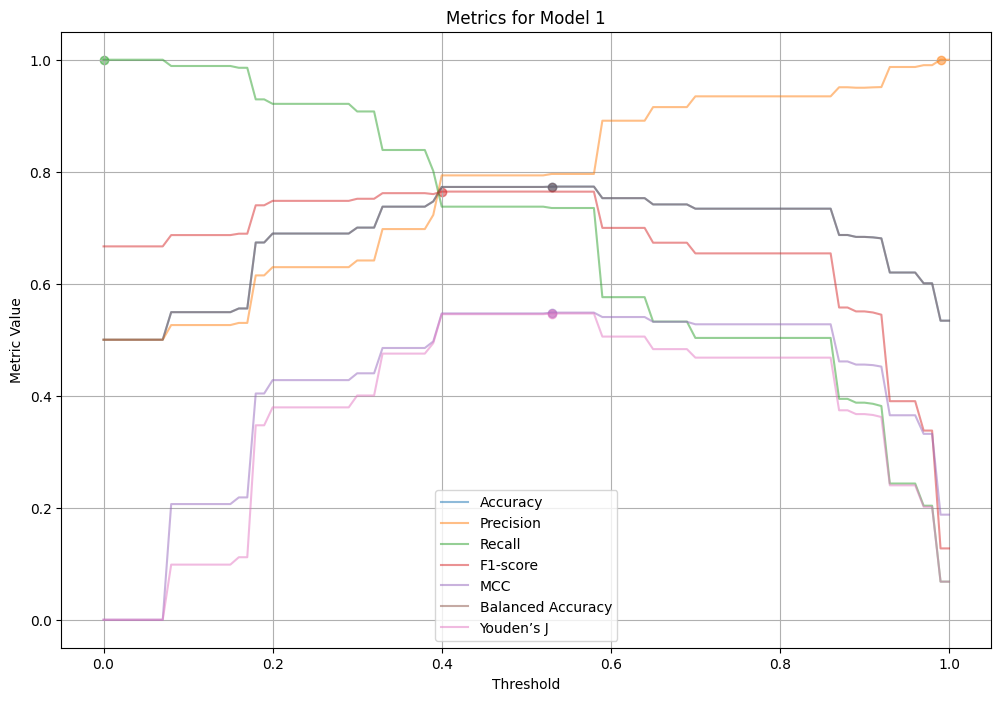

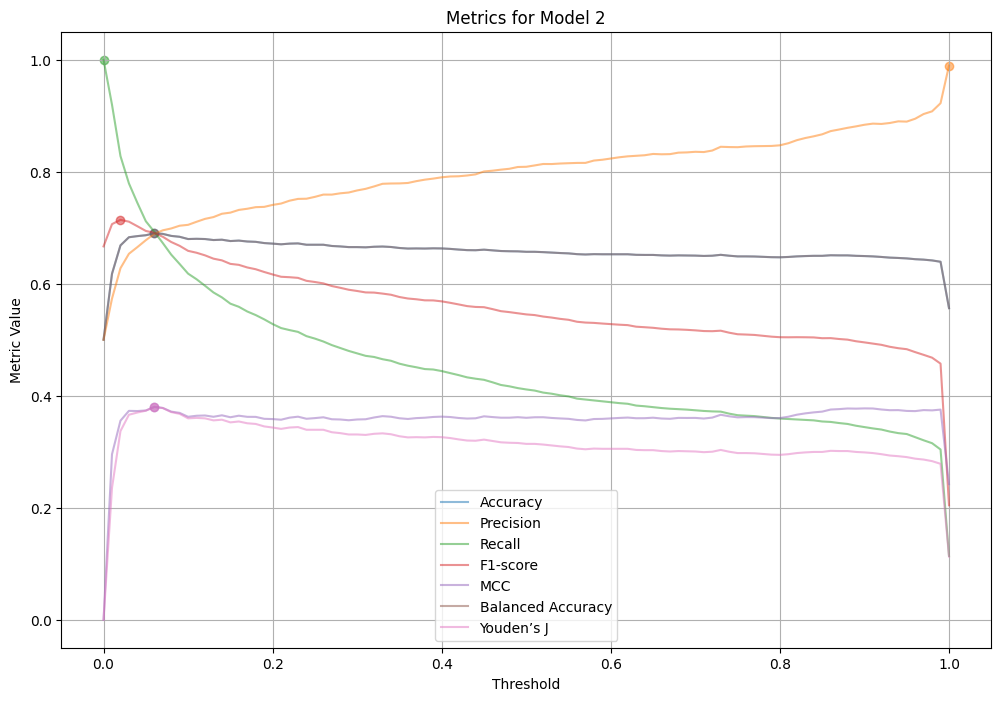

In [6]:
plot_metrics(metrics_model1, 'Model 1')
plot_metrics(metrics_model2, 'Model 2')

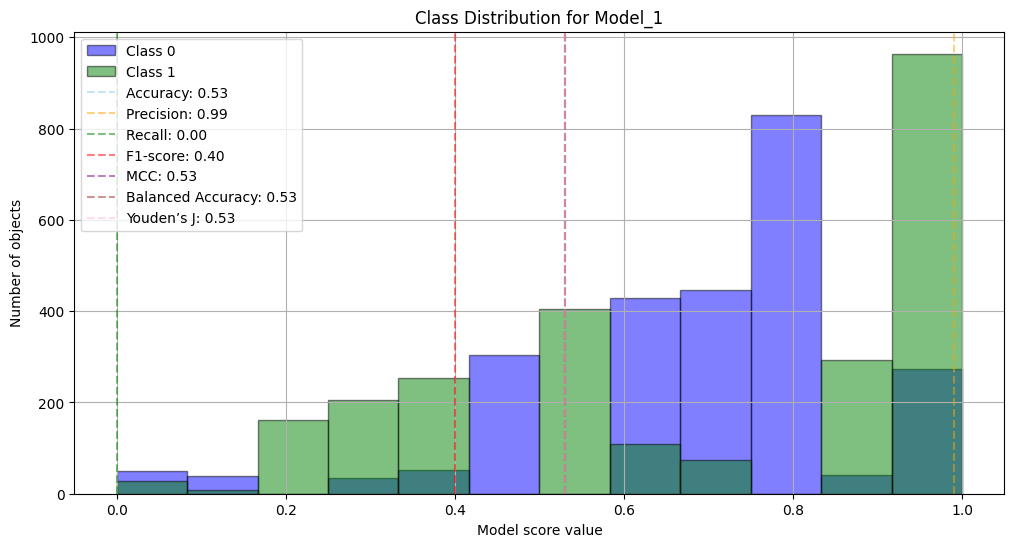

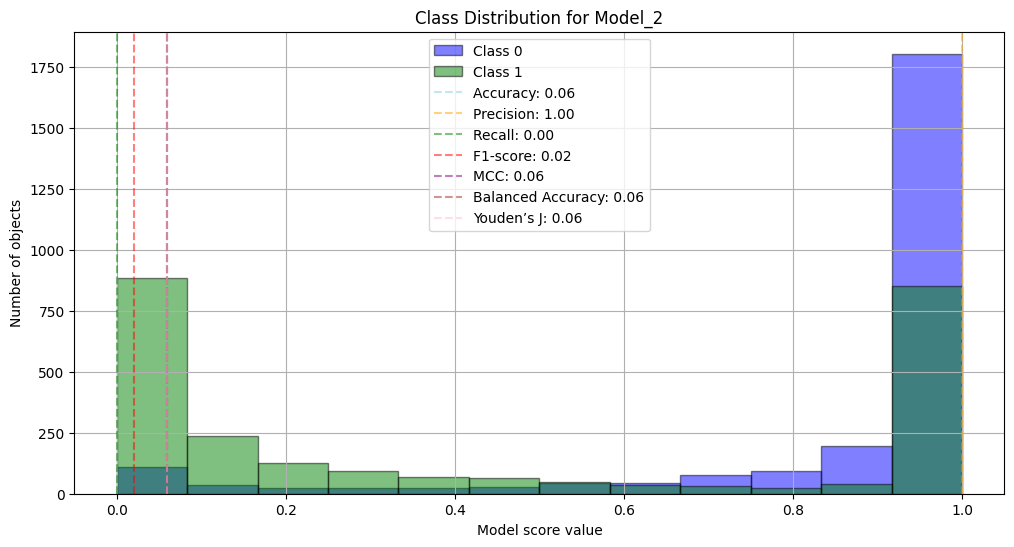

In [7]:
model1_optimal_thresholds = find_optimal_thresholds(metrics_model1)
model2_optimal_thresholds = find_optimal_thresholds(metrics_model2)

plot_class_distributions(data, 'Model_1', model1_optimal_thresholds)
plot_class_distributions(data, 'Model_2', model2_optimal_thresholds)

In [8]:
def plot_pr_roc(y_true, y_prob, model_name, optimal_thresholds):
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_prob)
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_prob)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'{model_name} PR Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    
    baseline_y = np.sum(y_true) / y_true.shape[0]
    plt.plot([0, 1], [baseline_y, baseline_y], linestyle='--', color='gray', label=f'Baseline: {baseline_y:.2f}')
    
    optimal_pr_threshold = optimal_thresholds['F1-score']
    idx = np.argmin(np.abs(pr_thresholds - optimal_pr_threshold))
    optimal_precision, optimal_recall, optimal_pr_threshold = precision[idx], recall[idx], pr_thresholds[idx]
    plt.scatter(optimal_recall, optimal_precision, label=f"({optimal_recall:.2f}, {optimal_precision:.2f}); t={optimal_pr_threshold:.2f}", zorder=2, color='red')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'{model_name} ROC Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')


    optimal_roc_threshold = optimal_thresholds['Youden’s J']
    idx = np.argmin(np.abs(roc_thresholds - optimal_roc_threshold))
    optimal_fpr, optimal_tpr, optimal_roc_threshold = fpr[idx], tpr[idx], roc_thresholds[idx]
    plt.scatter(optimal_fpr, optimal_tpr, label=f"({optimal_fpr:.2f}, {optimal_tpr:.2f}); t={optimal_roc_threshold:.2f}", zorder=2, color='red')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.grid(True)
    plt.legend()

    plt.show()

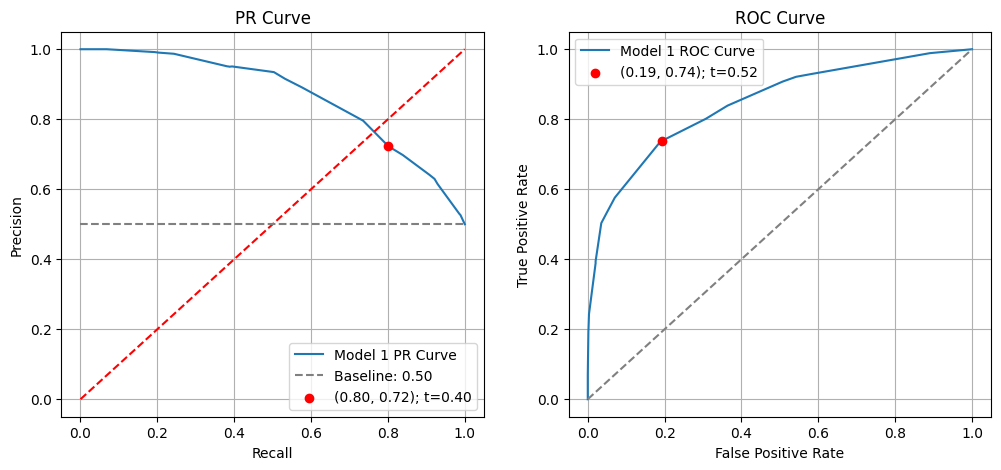

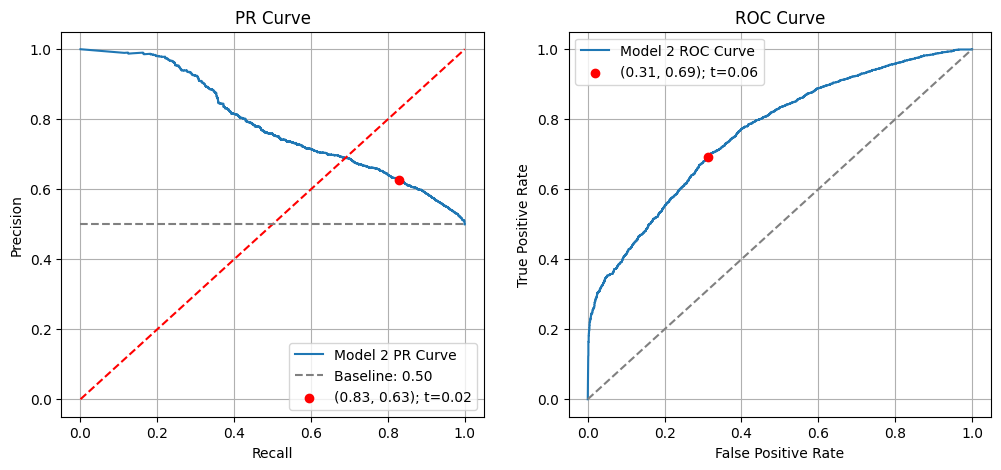

In [9]:
plot_pr_roc(data['GT'], data['Model_1_1'], 'Model 1', model1_optimal_thresholds)
plot_pr_roc(data['GT'], data['Model_2_1'], 'Model 2', model2_optimal_thresholds)

Step 4. Make conclusion about the quality of each model and select better one.

Можна помітити, що перша модель має кращі значення по кожній метриці.

Перевагу першої моделі також показують й PR- та ROC-криві (а також їх AUC значення): з них видно, що перша модель в середньому видає кращі результати.

Таким чином кращою я вважаю першу модель.

Step 5. Create new dataset removing from the original one (50 + 5K)% of objects from class 1 picked randomly.

In [10]:
BIRTHDAY = '21-11'

def calculate_K(birthday: str):
  day, _ = map(int, birthday.split('-'))
  return day % 9

K = calculate_K(BIRTHDAY)
n_objects_to_remove = int((50 + 5*K) / 100 * objects_of_class1_n)

new_data = data.drop(data[data['GT'] == 1].sample(n_objects_to_remove).index)

Step 6. Print out the percentage of removed objects and the amount of elements of each class after removing.

In [11]:
new_objects_of_class0_n = new_data[new_data['GT'] == 0].shape[0]
new_objects_of_class1_n = new_data[new_data['GT'] == 1].shape[0]
print(f'K is {K} so number of objects to remove: {n_objects_to_remove} (which is {50 + 5*K}% of objects of class 1)')
print(f'New objects of class 0: {new_objects_of_class0_n}')
print(f'New objects of class 1: {new_objects_of_class1_n}')

K is 3 so number of objects to remove: 1625 (which is 65% of objects of class 1)
New objects of class 0: 2500
New objects of class 1: 875


Step 7. Repeat step 3 for new dataset.

In [12]:
new_metrics_model1, new_pr_auc1, new_roc_auc1 = calculate_metrics(
  new_data['GT'].values, new_data['Model_1_1'].values, thresholds
)

new_metrics_model2, new_pr_auc2, new_roc_auc2 = calculate_metrics(
  new_data['GT'].values, new_data['Model_2_1'].values, thresholds
)

print(f"Model 1 PR AUC: {new_pr_auc1}, ROC AUC: {new_roc_auc1}")
print(f"Model 2 PR AUC: {new_pr_auc2}, ROC AUC: {new_roc_auc2}")

Model 1 PR AUC: 0.7418333541139529, ROC AUC: 0.8441899428571428
Model 2 PR AUC: 0.6048821964835266, ROC AUC: 0.7570228571428572


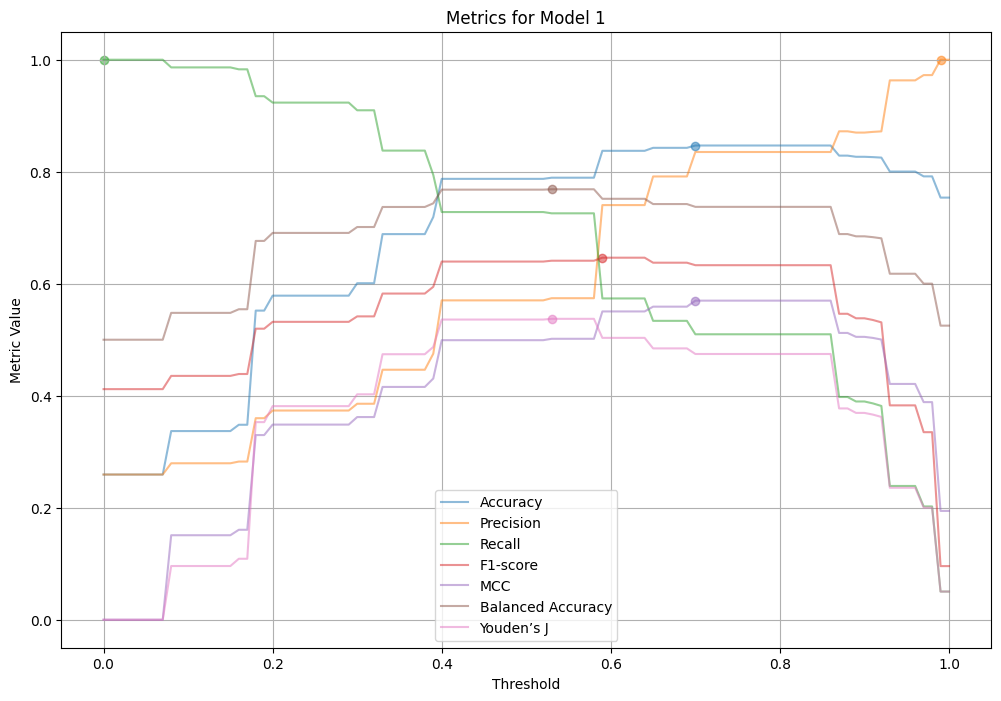

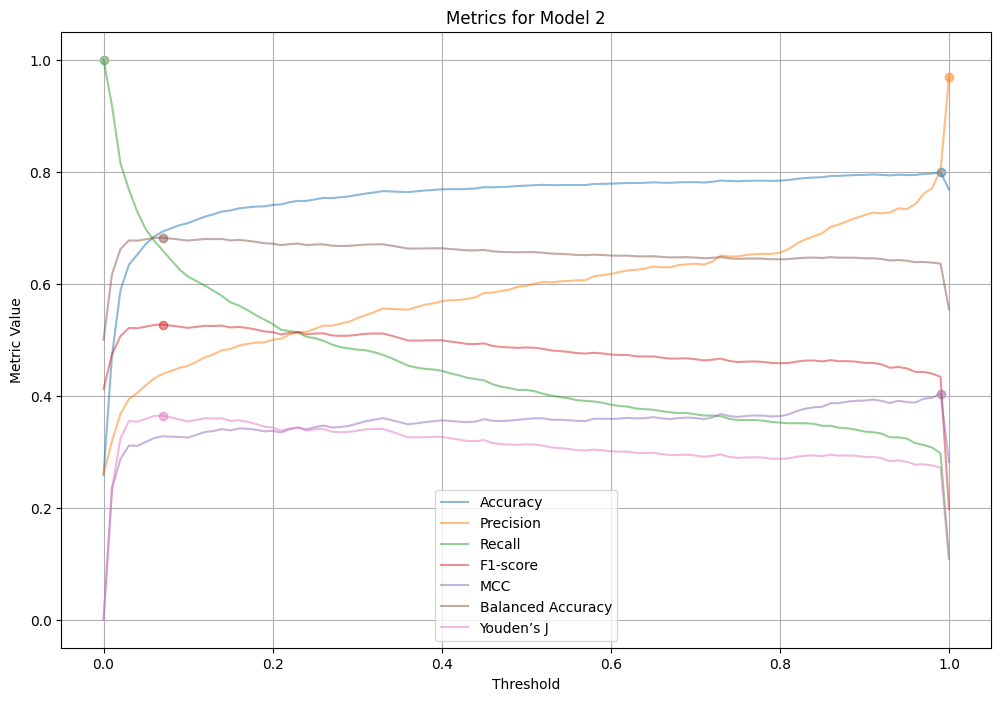

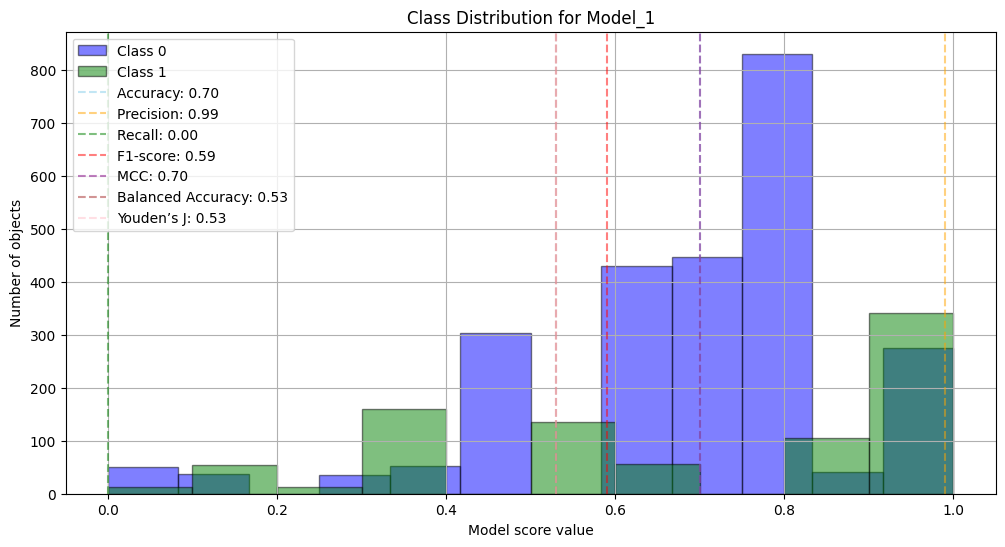

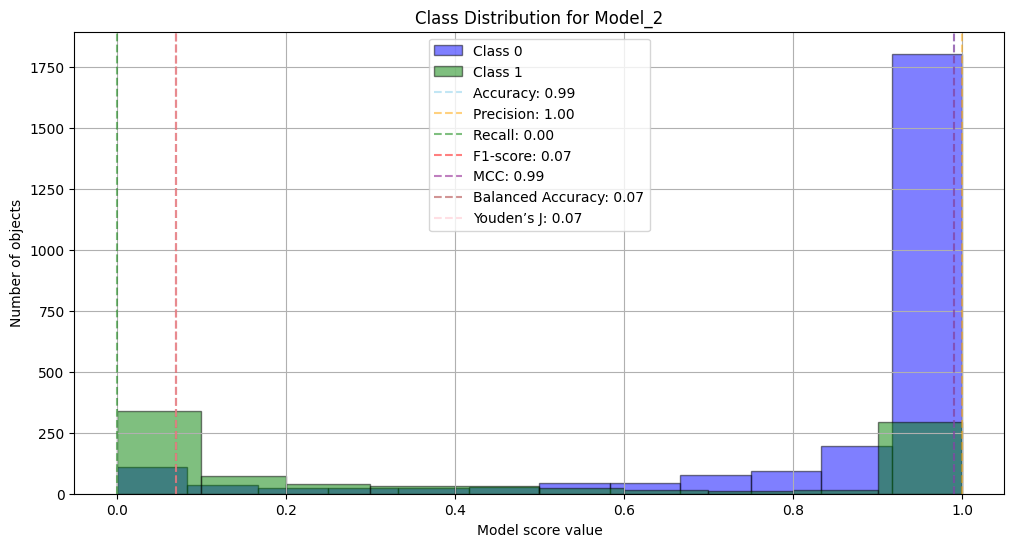

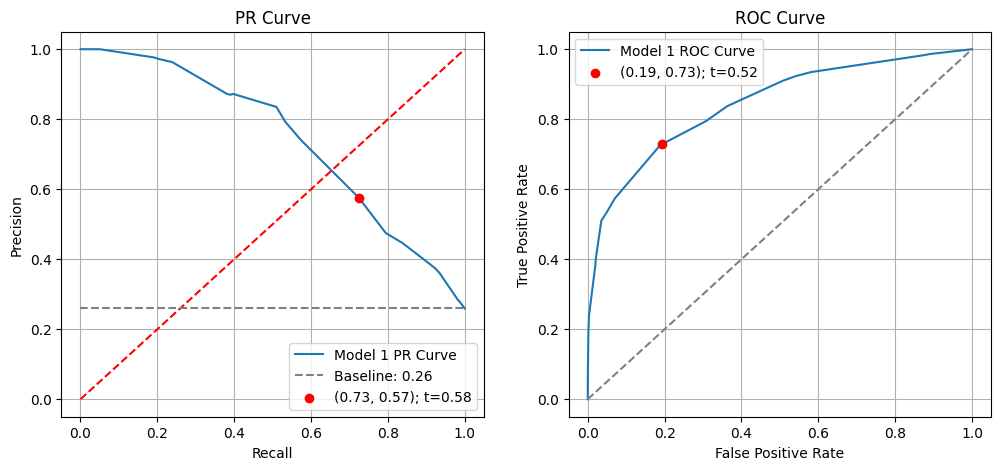

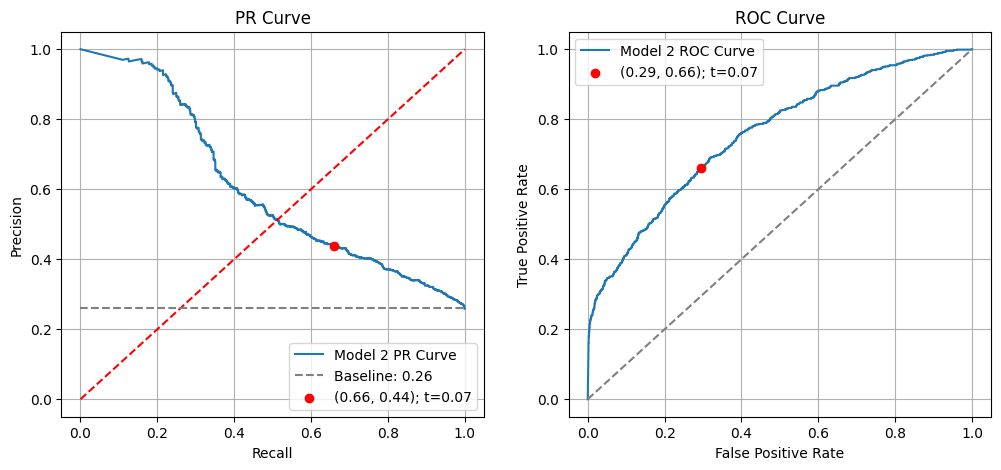

In [13]:
plot_metrics(new_metrics_model1, 'Model 1')
plot_metrics(new_metrics_model2, 'Model 2')

new_model1_optimal_thresholds = find_optimal_thresholds(new_metrics_model1)
new_model2_optimal_thresholds = find_optimal_thresholds(new_metrics_model2)

plot_class_distributions(new_data, 'Model_1', new_model1_optimal_thresholds)
plot_class_distributions(new_data, 'Model_2', new_model2_optimal_thresholds)

plot_pr_roc(new_data['GT'], new_data['Model_1_1'], 'Model 1', new_model1_optimal_thresholds)
plot_pr_roc(new_data['GT'], new_data['Model_2_1'], 'Model 2', new_model2_optimal_thresholds)

Step 8. Select new better model.

*New better model*: Все ще Модель 1

Step 9. Explain the impact of dataset imbalance on decision made.

Більшість метрик змінилися: якісь покращились, якісь погіршились (практично незмінними залишилися balanced accuracy та Youden's J). PR-крива також зазнала значного впливу (погіршилася), при цьому ROC крива практично не змінилася. Не зважаючи на це розбалансованність датасету не вплинула на вибрану модель, адже перша модель лишилася кращою.